<center><h1>Time Series Rainfall Analysis of the UK from 2015-2020</h1></center>

<h3 style="color:#023047;font-style:italic;">Required Python Libraries</h3>

- <b style="color:gray;">numpy</b>: for array handling
- <b style="color:gray;">pandas</b>: for data loading/cleaning/merging
- <b style="color:gray;">seaborn</b>: for beautiful charts
- <b style="color:gray;">matplotlib</b>: basic charts
- <b style="color:gray;">geopandas</b>: for plotting maps
- <b style="color:gray;">sklearn.IsolationForest</b>: Anomaly Detection

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

from sklearn.ensemble import IsolationForest

OSError: could not find or load spatialindex_c-64.dll

<h3 style="color:#023047;font-style:italic;">Styling Options</h3>

In [ ]:
# Styling Options
%matplotlib inline
sns.set_style("darkgrid", {"xtick.major.size": 8, "ytick.major.size": 8})

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(17,8)})
plt.rcParams["figure.figsize"]=17,8

# Change Pandas Api to see full value
pd.set_option('float_format', '{:f}'.format)

In [ ]:
# Change to working directory

os.chdir("C:/Users/iamta/project_data/rainfall_data")

In [4]:
# Make a list of column names for the dataset

columns = ['raingauge_id', 'id_type', 'ob_date', 'version_num', 'met_domain_name',
           'ob_end_ctime', 'ob_day_cnt', 'src_id', 'rec_st_ind', 'prcp_amt', 
           'ob_day_cnt_q', 'prcp_amt_q', 'meto_stmp_time', 'midas_stmp_etime', 'prcp_amt_j'
          ]

<h3 style="color:#023047;font-style:italic;">Collect yearly rainfall files into single file</h3>

In [5]:
# Get a list of files to be processed

files = []

for file in os.listdir(os.getcwd()):
    if file.endswith(".txt"):
        files.append(file)

<h3 style="color:#023047;font-style:italic">Combine into single dataframe</h3>

In [6]:
# Make a super dataframe

if os.path.exists('main.csv'):
    df = pd.read_csv('main.csv', low_memory=False)
else:
    df = pd.DataFrame()
    
    for file in files:
        print("Appending: " + file)
        df = pd.read_csv(file, usecols=range(15), lineterminator='\n', header=None, low_memory=False)
        df.columns = columns
        df['ob_date'] = df['ob_date'].astype('datetime64')
        df = df.append(df)
    print("Completed!")

In [7]:
# Dataset Information after Combining them together
print('Shape of dataset', df.shape)

Shape of dataset (2904981, 16)


<h3 style="color:#023047;font-style:italic;">Load Stations Dataframe</h3>

In [8]:
# Dataframe of all stations

stations = pd.read_csv('final_stations.csv')

<h2 style="color:#023047">Data Cleaning</h2>

In [9]:
# Change the data type of columns

df['ob_date'] = df['ob_date'].astype('datetime64')
df['meto_stmp_time'] = pd.to_datetime(df['meto_stmp_time'], errors='coerce')

df['prcp_amt'] = df['prcp_amt'].replace(' ', '', regex=True)
df['prcp_amt_q'] = df['prcp_amt_q'].replace(' ', '', regex=True)

df['prcp_amt'] = df['prcp_amt'].replace('', 0, regex=True)
df['prcp_amt_q'] = df['prcp_amt_q'].replace('', 0, regex=True)

df['prcp_amt'] = df['prcp_amt'].astype(float)
df['prcp_amt_q'] = df['prcp_amt_q'].astype(int)

In [10]:
# Cleaning the data

# Remove rows with version number - 0
df = df[df.version_num == 1]

# Remove id_type col
if 'id_type' in df.columns:
    df = df.drop('id_type', axis=1)

# Remove prcp_amt_j col
if 'prcp_amt_j' in df.columns:  
    df = df.drop('prcp_amt_j', axis=1)

# Remove ob_day_cnt > 31
df = df[df['ob_day_cnt'] < 31]

# Remove duplicate prcp amount
df = df.drop_duplicates(['raingauge_id','ob_date', 'src_id', 'prcp_amt_q'], keep='last')

# Remove Outliersdf from prcp
df = df[df['prcp_amt'] > 0]
            
df['prcp_amt_q'] = df['prcp_amt_q'].apply(lambda x: 6 if str(x).endswith('6') else 1)
df = df.query('prcp_amt_q == 6')

In [11]:
# Add new columns for easier access

df['day'] = df['ob_date'].dt.day
df['month'] = df['ob_date'].dt.strftime('%b')
df['year'] = df['ob_date'].dt.year

<h3 style="color:#023047;font-style:italic;">Save Dataframe after cleaning</h3>

In [12]:
# Save the cleaned file
if not os.path.exists('main.csv'):
    df.to_csv('main.csv', encoding='utf-8', index=False)

<h3 style="color:#023047;font-style:italic;">Split Dataframe into 2 chunks</h3>
<ol>
    <li>Unclean Dataframe (df name: <b>df</b>)</li>
    <li>Dataframe after anomaly detection (df name: <b>df_clean</b>)</li>
</ol>

<h2>Anomaly Detection Using Isolation Forest</h2>

In [13]:
# Define and Fit Model (Isolation Forest)

model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.05), max_features=1.0)
model.fit(df[['prcp_amt']])

# Add Scores and Anomaly Column

df['scores'] = model.decision_function(df[['prcp_amt']])
df['anomaly'] = model.predict(df[['prcp_amt']])

# Return Total Anomalies

# print('Total Rows:', df.shape[0])
# print('Total Anomalies Found:', list(df['anomaly']).count(-1))

# Removing Outliers

df_clean = df.query("anomaly != -1")
# print('After Removal Rows:', df_clean.shape[0])

<ul>
    <li>Contamination: <b>1%</b></li>
    <li>Total Rows: 2,899,225</li>
    <li>Total Anomalies Found: 28447</li>
    <li>After Removal Rows: 2870778</li>
</ul>
<ul>
    <li>Contamination: <b>4%</b></li>
    <li>Total Rows: 2899225</li>
    <li>Total Anomalies Found: 114504</li>
    <li>After Removal Rows: 2,784,721</li>
</ul>
<ul>
    <li>Contamination: <b>5%</b></li>
    <li>Total Rows: 2,899,225</li>
    <li>Total Anomalies Found: 143525</li>
    <li>After Removal Rows: 2,755,700</li>
</ul>
<ul>
    <li>Contamination: <b>7.5%</b></li>
    <li>Total Rows: 2,899,225</li>
    <li>Total Anomalies Found: 215094</li>
    <li>After Removal Rows: 2,684,131</li>
</ul>
<ul>
    <li>Contamination: <b>10%</b></li>
    <li>Total Rows: 2,899,225</li>
    <li>Total Anomalies Found: 287336</li>
    <li>After Removal Rows: 2,611,889</li>
</ul>

<center><h2>Comparison between before and after anomaly removal</h2></center>

<h3 style="color:#023047;">UK weather year-wise</h3>

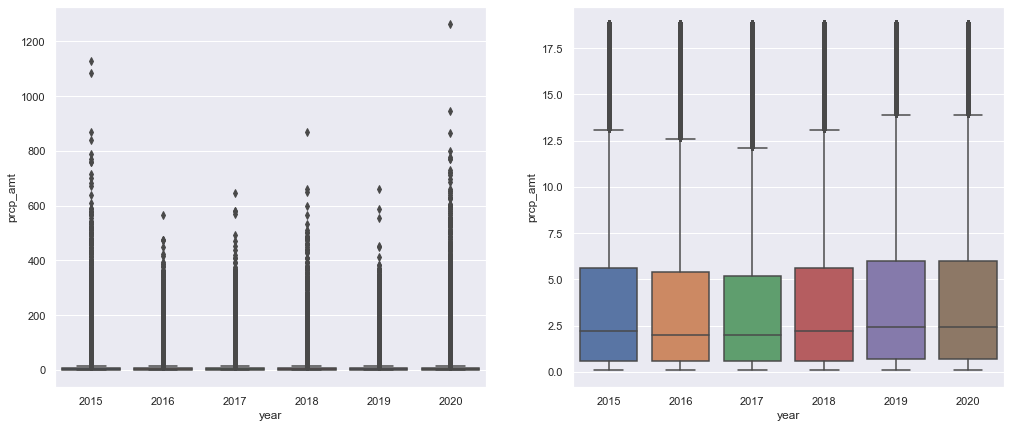

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(17,7))
sns.boxplot(x="year", y="prcp_amt", data=df, ax=ax[0])
sns.boxplot(x="year", y="prcp_amt", data=df_clean, ax=ax[1])
plt.show()

<h3 style="color:#023047;">UK weather month-wise</h3>

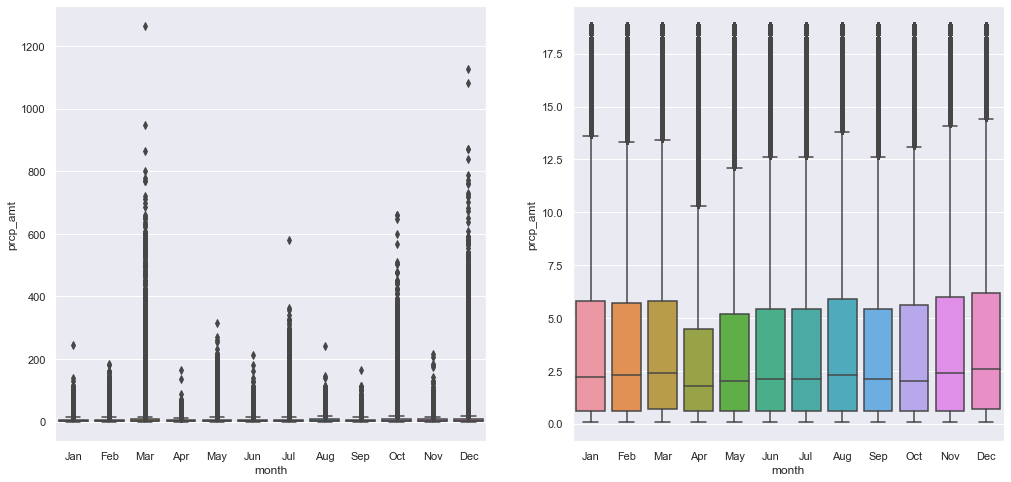

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(17,8))
sns.boxplot(x="month", y="prcp_amt", data=df, ax=ax[0])
sns.boxplot(x="month", y="prcp_amt", data=df_clean, ax=ax[1])
plt.show()

<h3 style="color:#023047;">UK weather day-wise</h3>

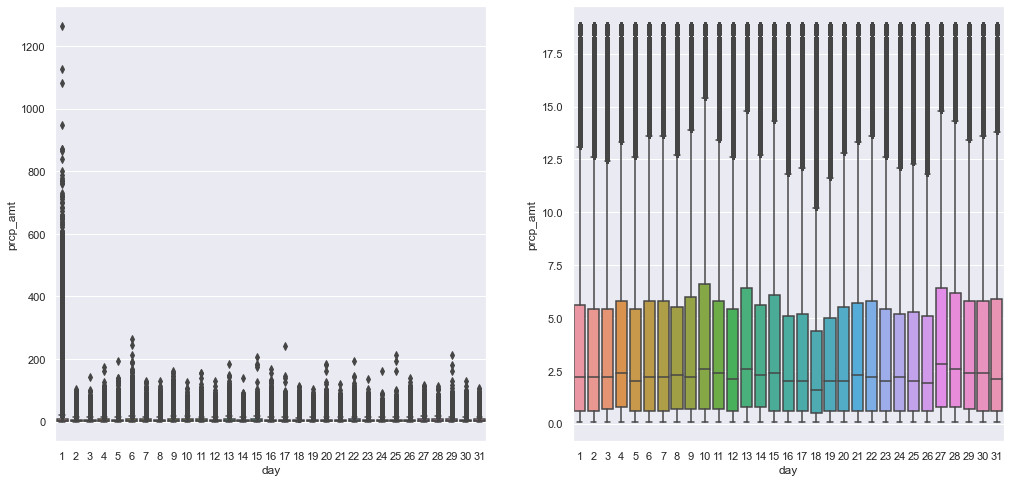

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(17,8))
sns.boxplot(x="day", y="prcp_amt", data=df, ax=ax[0])
sns.boxplot(x="day", y="prcp_amt", data=df_clean, ax=ax[1])
plt.show()

<h3 style="color:#023047;">UK weather trends during the years</h3>

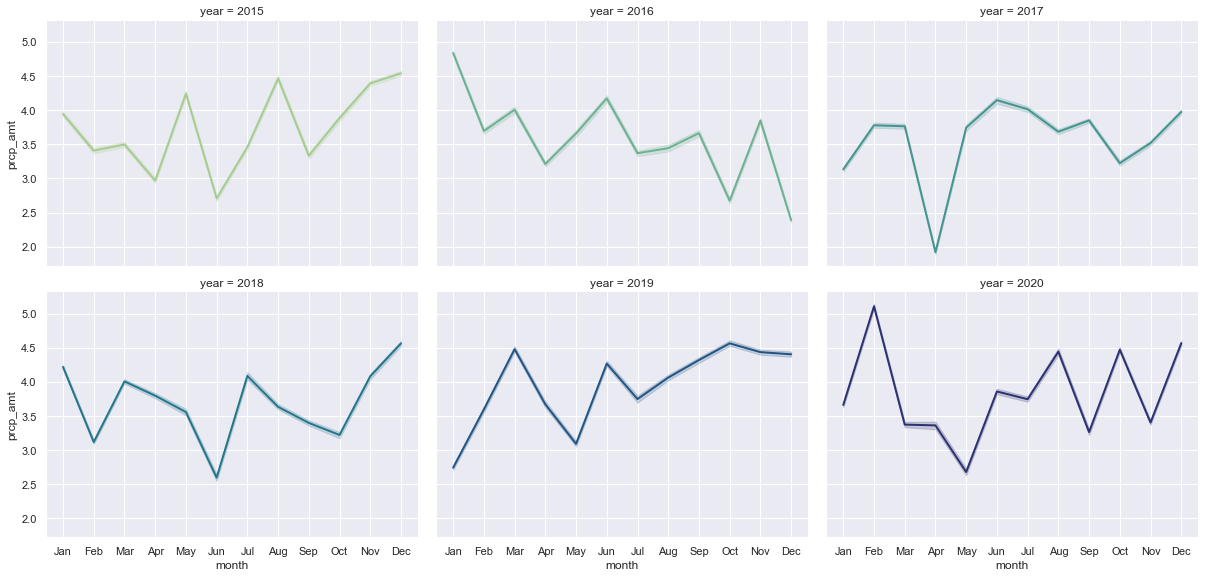

In [17]:
g = sns.relplot(data=df_clean, x="month", y="prcp_amt", col="year", hue="year", kind="line", palette="crest", 
            linewidth=2, zorder=5, col_wrap=3, height=4, aspect=1, legend=False)
g.fig.set_size_inches(17, 8)
plt.show()

<h3 style="color:#023047;">Average Rainfall Trend in UK during the year</h3>

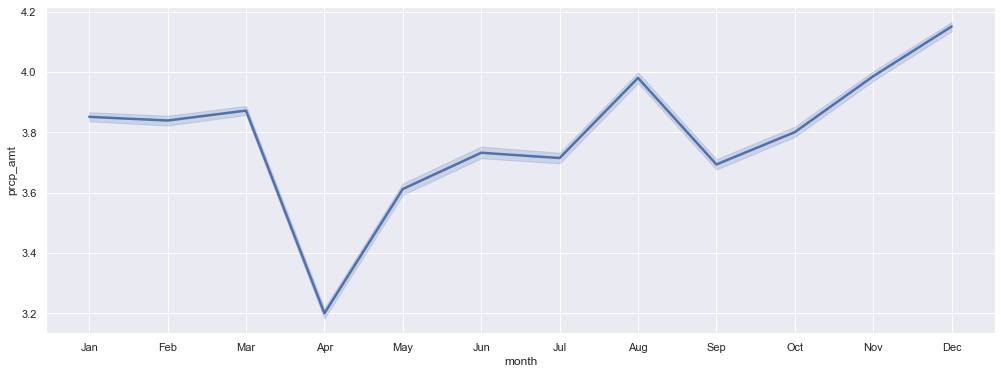

In [18]:
plt.figure(figsize=(17,6))
sns.lineplot(x="month", y="prcp_amt", data=df_clean, palette="tab10", linewidth=2.5)
plt.show()

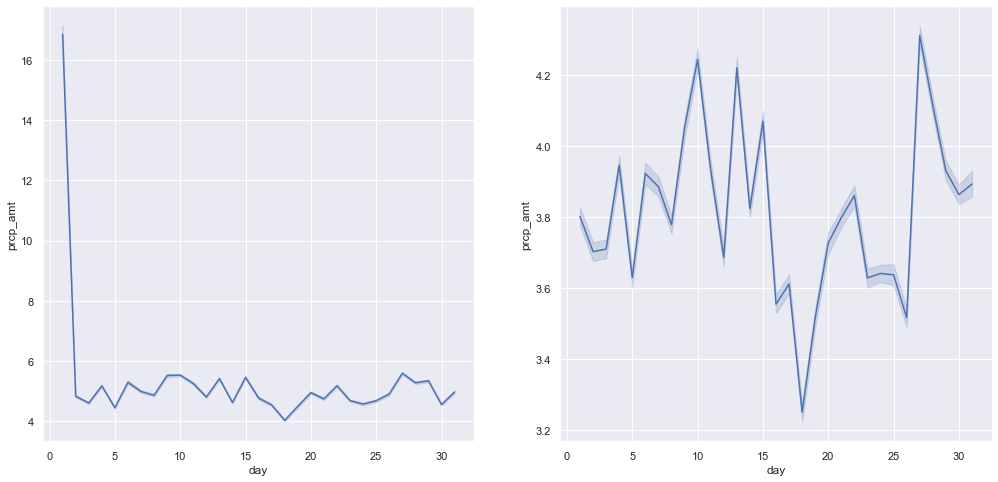

In [19]:
# Daily Rainfall Trend

fig, ax = plt.subplots(1, 2, figsize=(17,8))
sns.lineplot(x="day", y="prcp_amt", data=df, palette="tab10", linewidth=1.5, ax=ax[0])
sns.lineplot(x="day", y="prcp_amt", data=df_clean, palette="tab10", linewidth=1.5, ax=ax[1])
plt.show()

<h2 style="color:#023047;">Plotting the annual total precipitaion of the UK on Map</h2>

In [20]:
df = df.merge(stations[['src_id', 'latitude','longitude']], on='src_id', how="left")
df_clean = df_clean.merge(stations[['src_id', 'latitude','longitude']], on='src_id', how="left")

In [21]:
uk = gpd.read_file("C:\\Users\\iamta\\project_data\\rainfall_data\\uk_shape_file\\UnitedKingdom_Bound.shp")

<h3 style="color:#023047;">Total Rainfall - Year Wise</h3>

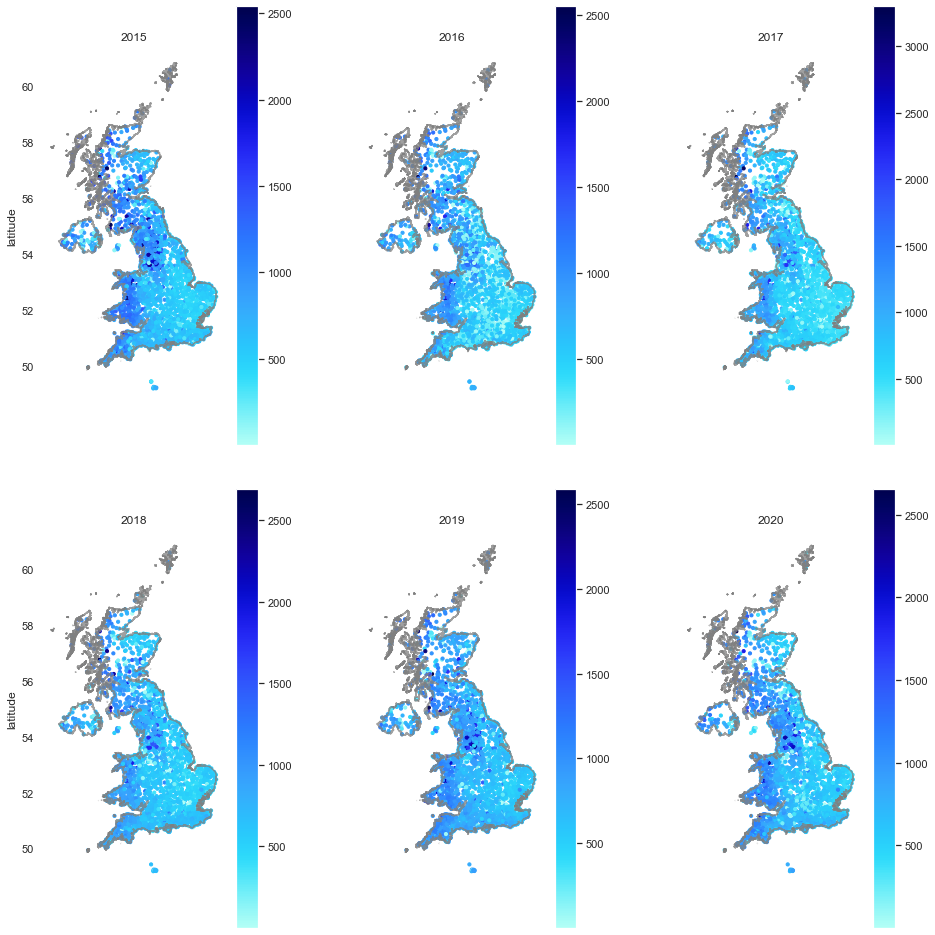

In [24]:
total_rainfall = df_clean.groupby(['src_id', 'year', 'latitude', 'longitude'])['prcp_amt'].sum().reset_index()

fig, ax = plt.subplots(2,3, sharex='all', sharey='all', figsize=(30,16))

_years = [2015, 2016, 2017, 2018, 2019, 2020]
n = 0

for ax in ax.flatten():
    uk.boundary.plot(color='grey', alpha=0.75, edgecolor='black', ax=ax)
    total_rainfall.query('year == '+str(_years[n])).plot(kind="scatter", x="longitude", y="latitude", alpha=1, label="rainfall",
        c=total_rainfall.query('year == '+str(_years[n]))["prcp_amt"], s=10, cmap=cc.cm.kbc_r, colorbar=True, ax=ax)
    ax.get_legend().remove()
    ax.title.set_text(str(_years[n]))
    n = n+1

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9, wspace=0.4, hspace=0.1)
plt.grid(linewidth=0.1)
plt.rcParams['axes.facecolor'] = 'none'
plt.show()

<h3 style="color:#023047;">Mean Rainfall - Month Wise</h3>

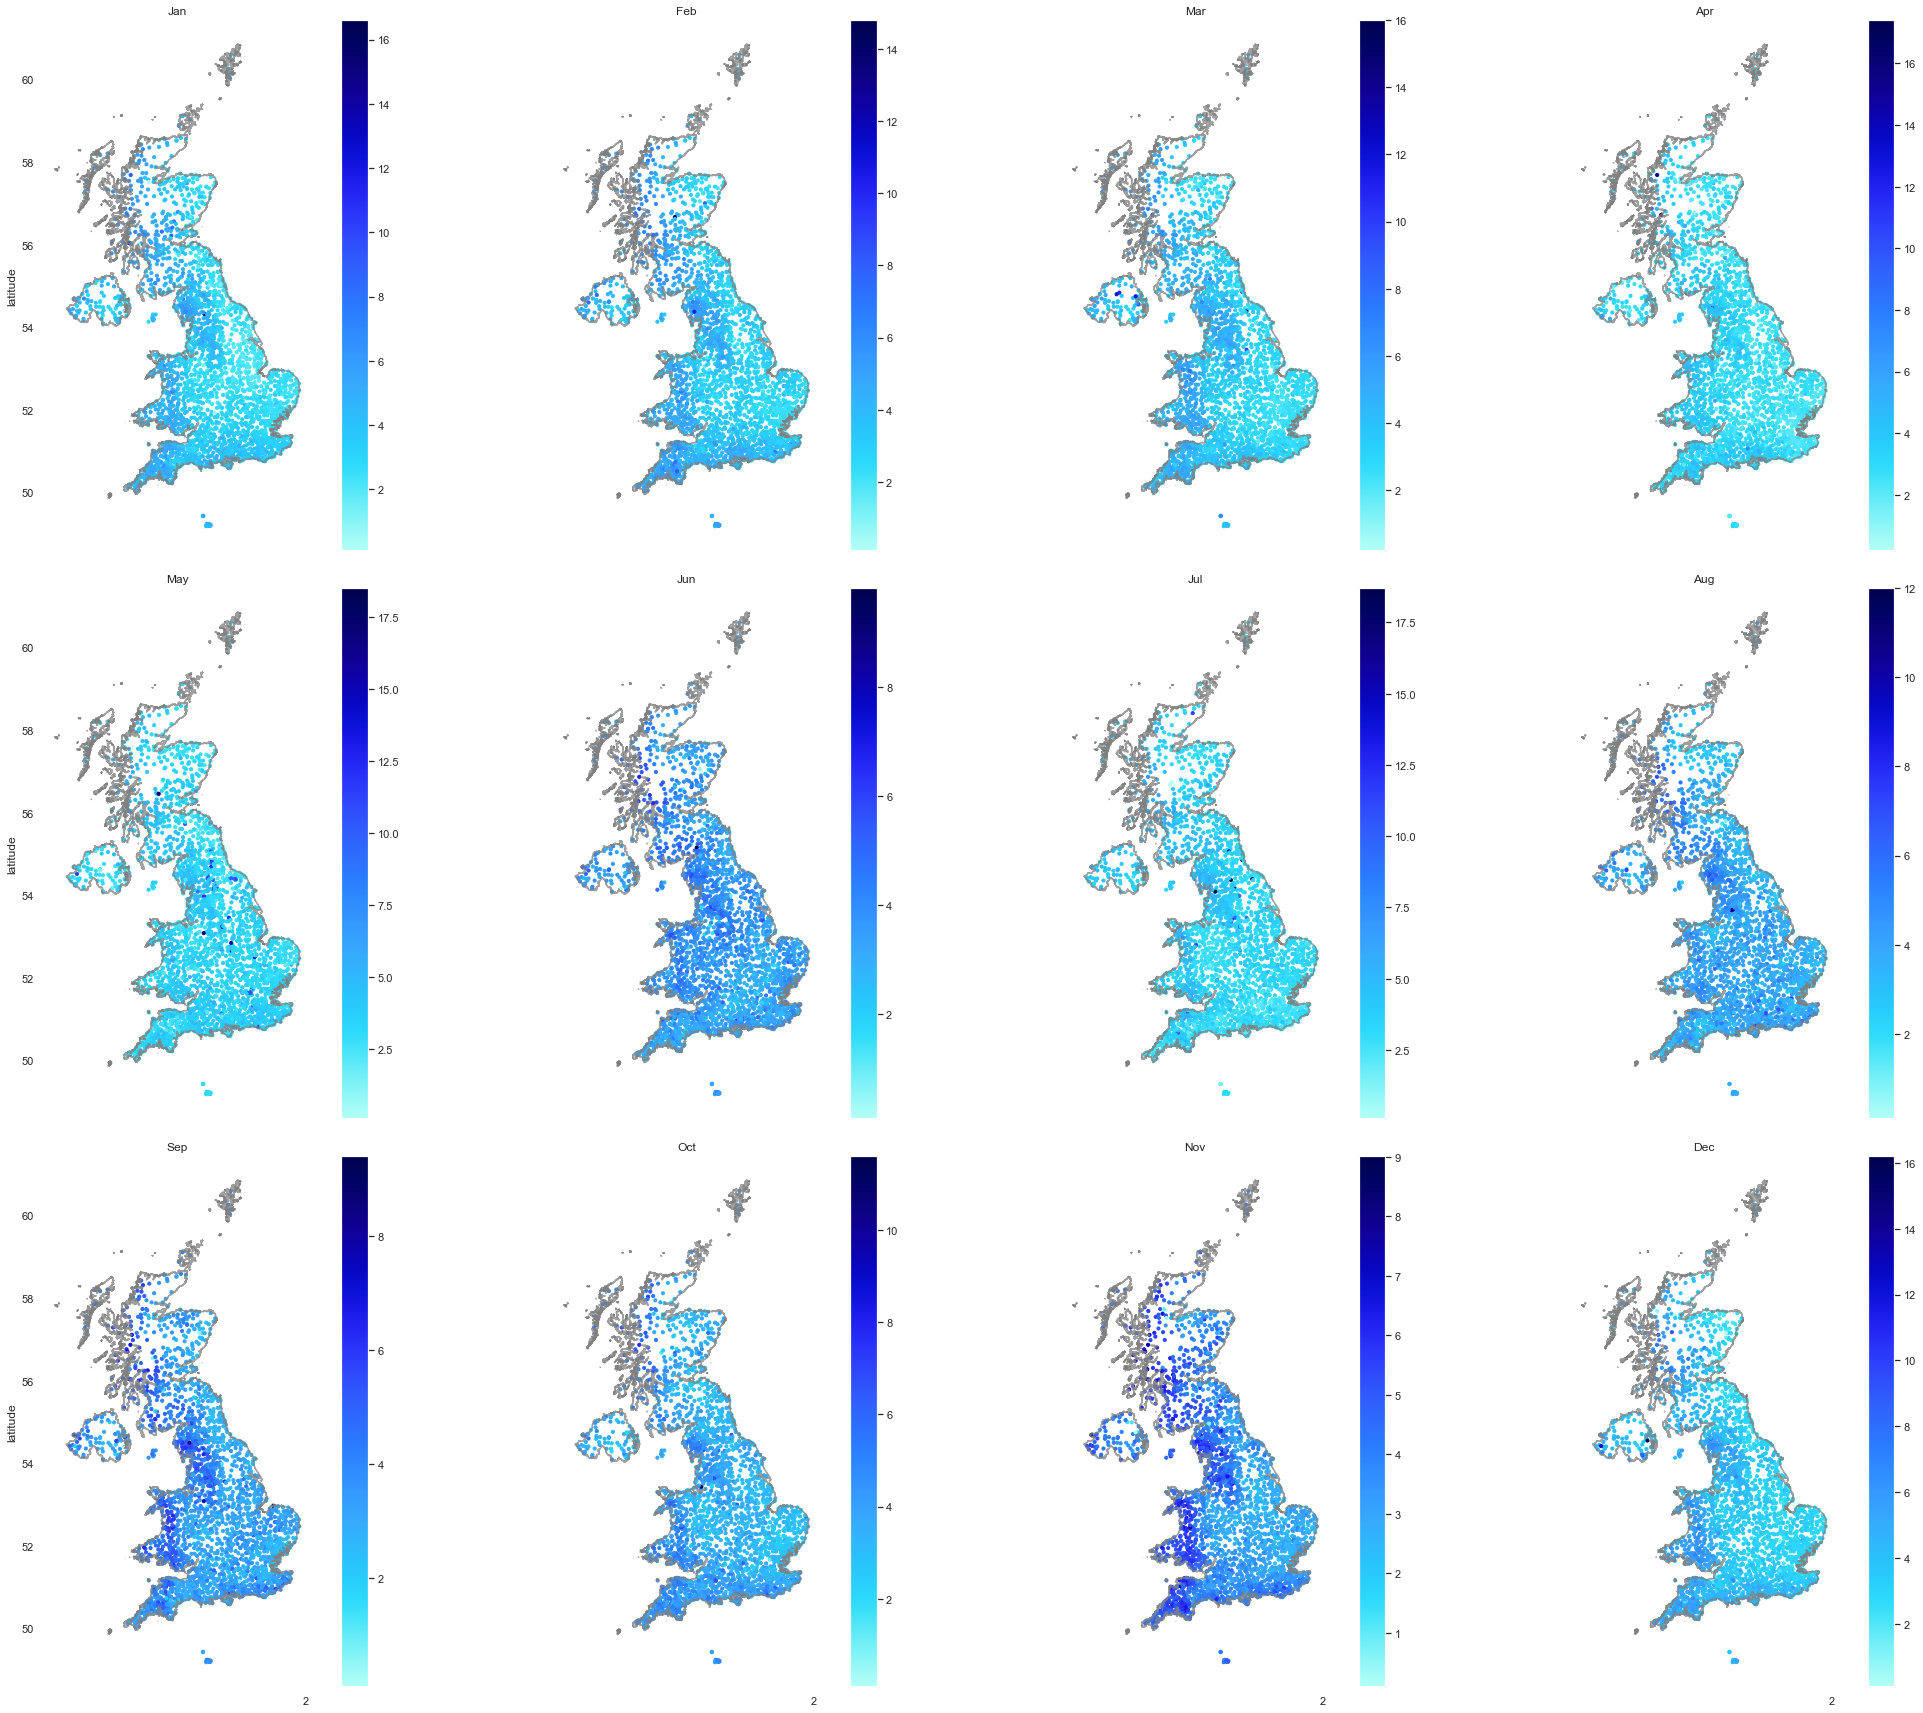

In [23]:
total_rainfall = df_clean.groupby(['src_id', 'month', 'latitude', 'longitude'])['prcp_amt'].mean().reset_index()

fig, ax = plt.subplots(3,4, sharex='all', sharey='all', figsize=(30,24))

_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
n = 0

for ax in ax.flatten():
    uk.boundary.plot(color='grey', alpha=0.75, edgecolor='black', ax=ax)
    total_rainfall.query('month == "'+str(_months[n])+'"').plot(kind="scatter", x="longitude", y="latitude", alpha=1, 
            label="rainfall", c=total_rainfall.query('month == "'+str(_months[n])+'"')["prcp_amt"], s=10, cmap=cc.cm.kbc_r, 
            colorbar=True, ax=ax)
    ax.title.set_text(str(_months[n]))
    ax.get_legend().remove()
    n = n+1

fig.tight_layout(pad=2.0)
plt.grid(linewidth=0.1)
plt.rcParams['axes.facecolor'] = 'none'
plt.show()